In [1]:
# Upload kaggle.json (your API key)
from google.colab import files
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!pip install kaggle
!kaggle datasets download -d msambare/fer2013
!unzip fer2013.zip

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: train/sad/Training_65242339.jpg  
  inflating: train/sad/Training_65267116.jpg  
  inflating: train/sad/Training_65275626.jpg  
  inflating: train/sad/Training_6529266.jpg  
  inflating: train/sad/Training_65329617.jpg  
  inflating: train/sad/Training_65338712.jpg  
  inflating: train/sad/Training_65338797.jpg  
  inflating: train/sad/Training_65387162.jpg  
  inflating: train/sad/Training_65404494.jpg  
  inflating: train/sad/Training_65426218.jpg  
  inflating: train/sad/Training_65430136.jpg  
  inflating: train/sad/Training_65437377.jpg  
  inflating: train/sad/Training_6545735.jpg  
  inflating: train/sad/Training_65463385.jpg  
  inflating: train/sad/Training_65473985.jpg  
  inflating: train/sad/Training_65502829.jpg  
  inflating: train/sad/Training_65505359.jpg  
  inflating: train/sad/Training_65508578.jpg  
  inflating: train/sad/Training_65516023.jpg  
  inflating: train/sad/Training_65524027.jpg  
 

In [2]:
# Imports
import os
import time
from typing import Tuple, List
from collections import Counter

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split

from torchvision import datasets, transforms, models

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight

from google.colab import drive

In [3]:
# Data preparation
drive.mount('/content/drive')


project = '/content/drive/MyDrive/UPF_DeepLearning_2025/PROJECT'
os.chdir(project)

results_path = 'results/'
os.makedirs(results_path, exist_ok=True)


train_dir = '/content/train'
test_dir = '/content/test'

img_height, img_width = 48, 48
batch_size = 32
num_classes = 7
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define transformations and normalization to dataset
train_transform = transforms.Compose([
    transforms.Lambda(lambda img: img.convert("RGB")),
    transforms.Resize((img_height, img_width)),
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop((img_height, img_width), scale=(0.7, 1.0)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ElasticTransform(alpha=250.0, sigma=10.0),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),

    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Lambda(lambda img: img.convert("RGB")),
    transforms.Resize((img_height, img_width)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Split dataset and apply transformations and normalization to dataset
full_train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)

train_size = int(0.8 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

val_dataset.dataset.transform = test_transform

test_dataset = datasets.ImageFolder(test_dir, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


# Detect and handle class imbalance
print("Classes:", full_train_dataset.classes)
print("Class to index mapping:", full_train_dataset.class_to_idx)

class_names = full_train_dataset.classes

print("\nImages for every emotion:")
class_counts = Counter(full_train_dataset.targets)


for class_idx, count in class_counts.items():
    emotion_name = full_train_dataset.classes[class_idx]
    print(f"'{emotion_name}': {count}")
print(f"Number of images in the training set: {len(train_dataset)}")
print(f"Number of images in the validation set: {len(val_dataset)}")
print(f"Number of images in the test set: {len(test_dataset)}")

train_labels_for_weights = [label for _, label in full_train_dataset]

class_weights_np = compute_class_weight(class_weight='balanced',
                                        classes=np.unique(train_labels_for_weights),
                                        y=train_labels_for_weights)

class_weights = torch.tensor(class_weights_np, dtype=torch.float).to(device)
print(f"Class weights: {class_weights.tolist()}")


Mounted at /content/drive
Classes: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
Class to index mapping: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}

Images for every emotion:
'angry': 3995
'disgust': 436
'fear': 4097
'happy': 7215
'neutral': 4965
'sad': 4830
'surprise': 3171
Number of images in the training set: 22967
Number of images in the validation set: 5742
Number of images in the test set: 7178
Class weights: [1.0266046524047852, 9.40661907196045, 1.001046061515808, 0.5684387683868408, 0.8260394334793091, 0.849127471446991, 1.2933729887008667]


In [4]:
# Our VGG implementation
class CustomVGG19(nn.Module):
    def __init__(self, num_classes=7, fine_tune_layers=5):
        super(CustomVGG19, self).__init__()

        # Load pretrained weights for vgg19 with Imagenet
        self.vgg19_features = models.vgg19(weights=models.VGG19_Weights.IMAGENET1K_V1).features

        '''
        # Uncomment when using Gradcam
        for i, layer in enumerate(self.vgg19_features):
            if isinstance(layer, nn.ReLU):
                self.vgg19_features[i] = nn.ReLU(inplace=False)
        '''
        # Freeze / unfreeze layers in network
        for param in self.vgg19_features.parameters():
            param.requires_grad = False

        feature_modules = list(self.vgg19_features.children())
        unfrozen_count = 0
        for child in reversed(feature_modules):
            if unfrozen_count >= fine_tune_layers:
                break
            for param in child.parameters():
                param.requires_grad = True
            unfrozen_count += 1

        if fine_tune_layers > 0:
            print(f"Unfrozen the last {unfrozen_count} VGG19 feature modules for fine-tuning.")

        # Change output to 7 classes to match FER 2013 classes
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Sequential(
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),  # Change to false when using Gradcam
            nn.Dropout(0.7),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.vgg19_features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

#Train step
def train_step(model: nn.Module, dataloader, criterion, optimizer, device) -> Tuple[float, float]:
    model.train()
    model.to(device)
    total_loss, correct, total = 0.0, 0, 0

    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device).long()

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)

    return total_loss / len(dataloader), 100 * correct / total

#Val step
def val_step(model: nn.Module, dataloader, criterion, device) -> Tuple[float, float]:
    model.eval()
    model.to(device)
    total_loss, correct, total = 0.0, 0, 0

    with torch.inference_mode():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            correct += (outputs.argmax(1) == labels).sum().item()
            total += labels.size(0)

    return total_loss / len(dataloader), 100 * correct / total

#Train
def train(model, train_loader, val_loader, criterion, optimizer, device,
          num_epochs=10, model_path='best_model.pt', scheduler=None) -> Tuple[List[float], List[float], List[float], List[float]]:

    best_val_loss = float('inf')
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    epochs_no_improve = 0
    early_stop = 20

    for epoch in range(num_epochs):
        t_loss, t_acc = train_step(model, train_loader, criterion, optimizer, device)
        v_loss, v_acc = val_step(model, val_loader, criterion, device)

        train_losses.append(t_loss)
        val_losses.append(v_loss)
        train_accuracies.append(t_acc)
        val_accuracies.append(v_acc)

        if scheduler:
            scheduler.step(v_loss)

        print(f"Epoch {epoch+1}: Train Loss {t_loss:.4f} | Train Acc {t_acc:.2f}% | Val Loss {v_loss:.4f} | Val Acc {v_acc:.2f}%")

        if v_loss < best_val_loss:
            best_val_loss = v_loss
            epochs_no_improve = 0
            torch.save(model.state_dict(), model_path)
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= early_stop:
            print(f"Early stopping after {early_stop} epochs without improvement.")
            break

    return train_losses, train_accuracies, val_losses, val_accuracies

#Inference
def inference(model: nn.Module, test_loader, device) -> Tuple[float, np.ndarray, np.ndarray]:
    model.eval()
    model.to(device)
    correct, total = 0, 0
    all_labels, all_preds = [], []

    with torch.inference_mode():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = outputs.argmax(dim=1)

            correct += (preds == labels).sum().item()
            total += labels.size(0)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    return 100 * correct / total, np.array(all_labels), np.array(all_preds)

# Loss function
class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, smoothing=0.1, num_classes=None, weight=None, reduction='mean'):
        super(LabelSmoothingCrossEntropy, self).__init__()
        assert 0. <= smoothing <= 1., 'smoothing must be in [0, 1]'
        assert num_classes is not None, 'num_classes must be specified'

        self.smoothing = smoothing
        self.num_classes = num_classes
        self.weight = weight
        self.reduction = reduction

    def forward(self, input, target):
        log_probs = F.log_softmax(input, dim=-1)
        smoothed_target = torch.zeros_like(log_probs).scatter_(1, target.unsqueeze(1), 1.0)
        smoothed_target = smoothed_target * (1.0 - self.smoothing) + (self.smoothing / self.num_classes)
        loss = -(smoothed_target * log_probs)

        if self.weight is not None:
            loss = loss * self.weight[target].unsqueeze(1)

        if self.reduction == 'mean':
            return loss.sum() / input.shape[0]
        elif self.reduction == 'sum':
            return loss.sum()
        else:
            return loss.sum(dim=-1)

In [ ]:
#Define hyperparameters
model = CustomVGG19(num_classes=num_classes).to(device)

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-3)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=7)

criterion = LabelSmoothingCrossEntropy(smoothing=0.1, num_classes=7, weight=class_weights.to(device))

model_path = os.path.join(results_path, 'best_customvgg19_fer2013_model.pt')

# Train from scratch
num_epochs = 50
train_losses, train_accuracies, val_losses, val_accuracies = train(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    num_epochs=num_epochs,
    model_path='best_customvgg19_fer2013_model.pt',
    scheduler = scheduler,
)

# Loss and accurracy curves on training set
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.ylimit(0,3)

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.tight_layout()
plt.show()
plt.ylimit(20,100)

Unfrozen the last 5 VGG19 feature modules for fine-tuning.

--- Evaluation on the Test Set ---
Final model accuracy on the test set: 59.11%

--- Classification Report ---
              precision    recall  f1-score   support

       angry       0.52      0.48      0.50       958
     disgust       0.67      0.63      0.65       111
        fear       0.46      0.49      0.47      1024
       happy       0.79      0.74      0.77      1774
     neutral       0.52      0.56      0.54      1233
         sad       0.45      0.48      0.46      1247
    surprise       0.77      0.73      0.75       831

    accuracy                           0.59      7178
   macro avg       0.60      0.59      0.59      7178
weighted avg       0.60      0.59      0.59      7178


--- Confusion Matrix ---


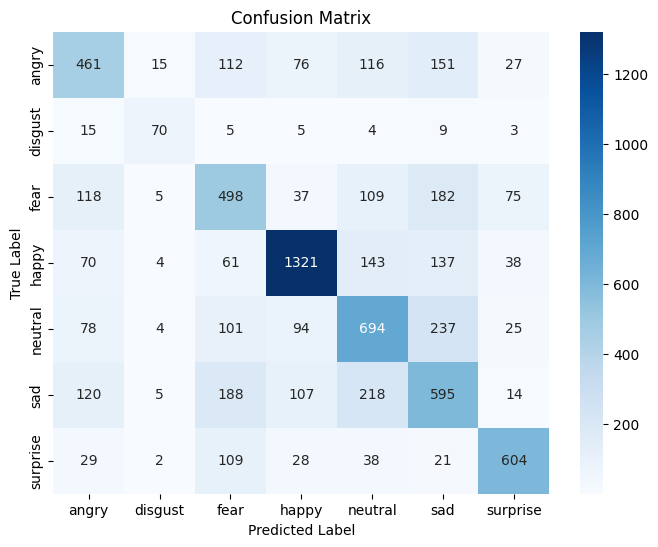

In [6]:
# Load model and evaluation on test set
model = CustomVGG19(num_classes=num_classes).to(device)
print("\n--- Evaluation on the Test Set ---")
model.load_state_dict(torch.load(os.path.join(results_path, 'best_customvgg19_fer2013_model.pt'), map_location=device))

test_accuracy, true_labels, predicted_labels = inference(model, test_loader, device)

print(f"Final model accuracy on the test set: {test_accuracy:.2f}%")

#Classificacion Report and Confusion Matrix on test set
print("\n--- Classification Report ---")
# Make sure class_names is defined.
print(classification_report(true_labels, predicted_labels, target_names=class_names))

print("\n--- Confusion Matrix ---")
cm = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# GradCam Implementation
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.model.eval()
        self.target_layer = target_layer

        self.gradients = None
        self.activations = None

        self.target_layer.register_forward_hook(self._save_activation)
        self.target_layer.register_full_backward_hook(self._save_gradient)

    def _save_activation(self, module, input, output):
        self.activations = output.detach()

    def _save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach()

    def generate(self, input_tensor, class_idx=None):
        self.model.zero_grad()
        output = self.model(input_tensor)

        if class_idx is None:
            class_idx = output.argmax(dim=1).item()

        loss = output[0, class_idx]
        loss.backward()

        pooled_gradients = torch.mean(self.gradients, dim=[0, 2, 3])

        activations = self.activations[0].clone()

        for i in range(activations.shape[0]):
            activations[i] *= pooled_gradients[i]

        heatmap = torch.sum(activations, dim=0)
        heatmap = F.relu(heatmap)
        heatmap /= torch.max(heatmap) + 1e-6

        return heatmap.cpu().numpy()

#Visualization function
def show_gradcam_on_image(img_tensor, heatmap, title="", alpha=0.4):
    img = img_tensor.squeeze().cpu().numpy().transpose(1, 2, 0)

    img = (img * np.array([0.229, 0.224, 0.225])) + np.array([0.485, 0.456, 0.406])
    img = np.clip(img * 255.0, 0, 255).astype(np.uint8)

    heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)

    img_bgr = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

    superimposed_img = cv2.addWeighted(heatmap_colored, alpha, img_bgr, 1 - alpha, 0)

    superimposed_img_rgb = cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)

    plt.imshow(superimposed_img_rgb) # Mostrar la imagen convertida a RGB
    plt.title(title)
    plt.axis('off')
    plt.show()

#Visualize multiple gradcams for each class
def apply_gradcam_multiple_per_class(model, dataloader, device, class_names, num_images_per_class=2):

    target_layer = None
    for i in reversed(range(len(model.vgg19_features))):
        if isinstance(model.vgg19_features[i], torch.nn.Conv2d):
            target_layer = model.vgg19_features[i]
            break

    if target_layer is None:
        print("No se encontró una capa convolucional en las features de VGG19.")
        return

    gradcam = GradCAM(model, target_layer)
    seen_classes_count = {class_idx: 0 for class_idx in range(len(class_names))}

    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)

        for i in range(images.size(0)):
            label = labels[i].item()

            if seen_classes_count[label] < num_images_per_class:
                input_tensor = images[i].unsqueeze(0)

                with torch.no_grad():
                    output = model(input_tensor)
                    predicted_class_idx = output.argmax(dim=1).item()
                    predicted_class_name = class_names[predicted_class_idx]


                heatmap = gradcam.generate(input_tensor, class_idx=label)

                print(f"Processing image for class: {class_names[label]} (Image {seen_classes_count[label] + 1}/{num_images_per_class})")

                show_gradcam_on_image(images[i].unsqueeze(0).cpu(), heatmap, title=f"True: {class_names[label]} | Pred: {predicted_class_name}")

                seen_classes_count[label] += 1

        if all(count >= num_images_per_class for count in seen_classes_count.values()):
            return

Unfrozen the last 5 VGG19 feature modules for fine-tuning.
Processing image for class: fear (Image 1/2)


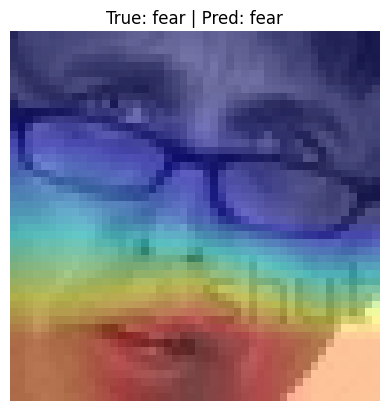

Processing image for class: fear (Image 2/2)


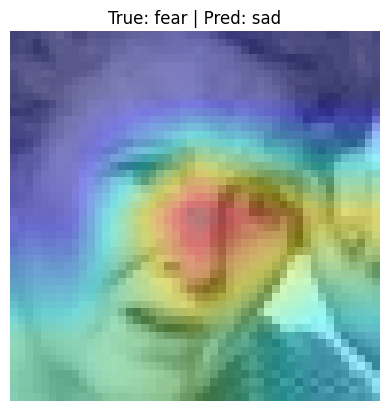

Processing image for class: happy (Image 1/2)


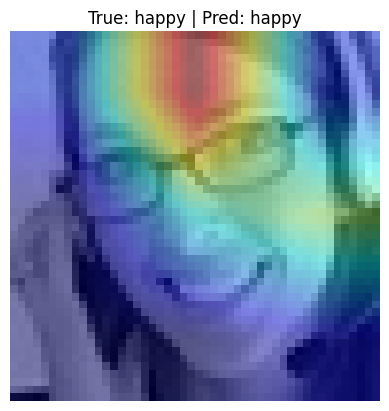

Processing image for class: happy (Image 2/2)


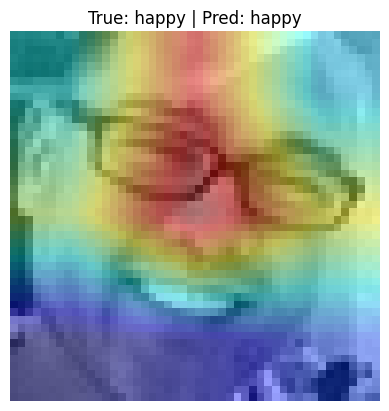

Processing image for class: sad (Image 1/2)


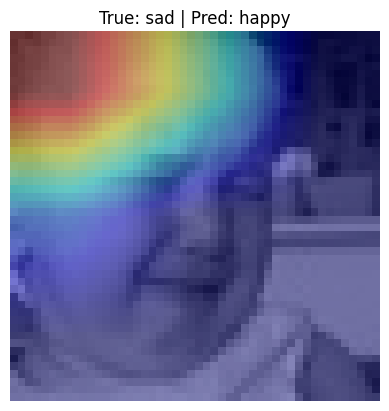

Processing image for class: neutral (Image 1/2)


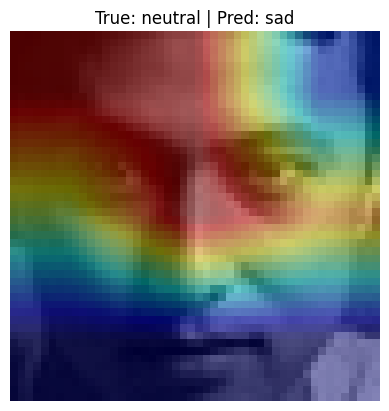

Processing image for class: surprise (Image 1/2)


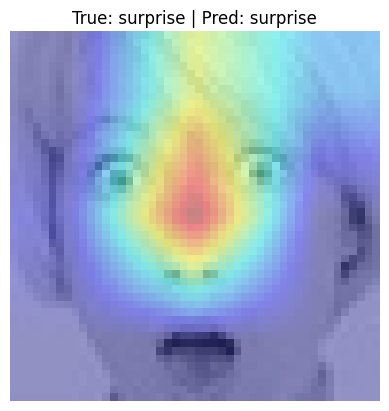

Processing image for class: surprise (Image 2/2)


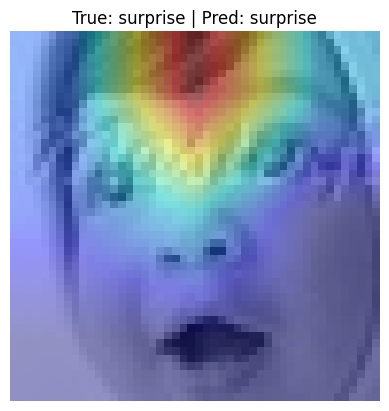

Processing image for class: sad (Image 2/2)


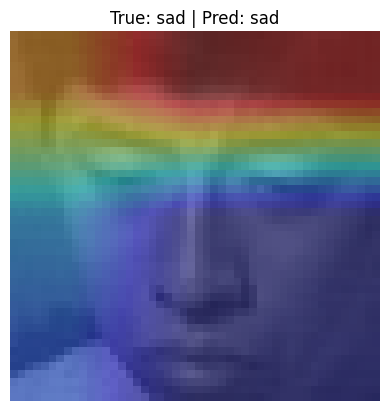

Processing image for class: neutral (Image 2/2)


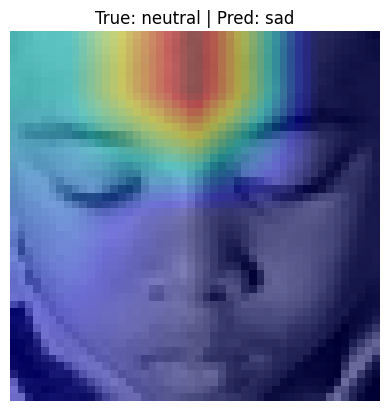

Processing image for class: angry (Image 1/2)


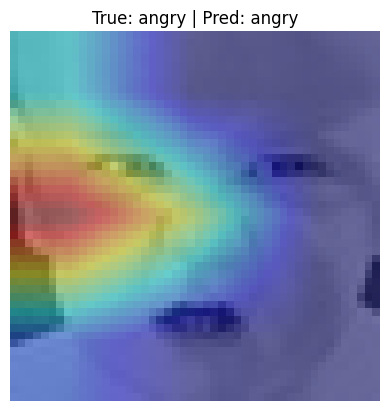

Processing image for class: disgust (Image 1/2)


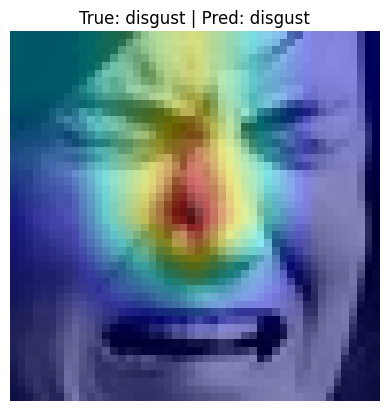

Processing image for class: disgust (Image 2/2)


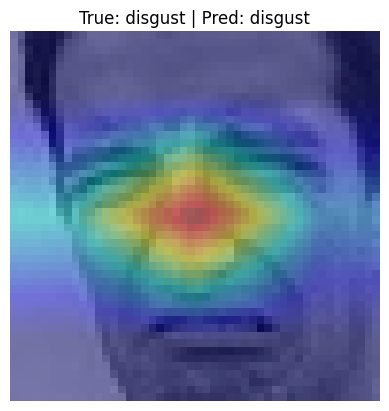

Processing image for class: angry (Image 2/2)


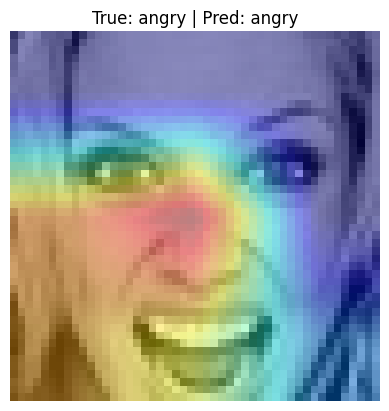

In [ ]:
# INSTRUCCIONS ON HOW TO USE Grad-CAM: Replace ALL ReLU(inplace=True) ->  ReLU(inplace=False)
# or execute VGG code below
model = CustomVGG19(num_classes=7)
model.load_state_dict(torch.load('results/best_customvgg19_fer2013_model.pt', map_location='cuda' if torch.cuda.is_available() else 'cpu'))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
model.eval()

lacss_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

test_transform = transforms.Compose([
    transforms.Lambda(lambda img: img.convert("RGB")),
    transforms.Resize((48, 48)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])
test_dataset = datasets.ImageFolder('/content/test', transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

apply_gradcam_multiple_per_class(model, test_loader, device, class_names, num_images_per_class=2)


In [ ]:
# VGG for GradCam
class CustomVGG19(nn.Module):
    def __init__(self, num_classes=7, fine_tune_layers=5):
        super(CustomVGG19, self).__init__()

        # Load pretrained weights for vgg19 with Imagenet
        self.vgg19_features = models.vgg19(weights=models.VGG19_Weights.IMAGENET1K_V1).features

        # Uncomment when using Gradcam
        for i, layer in enumerate(self.vgg19_features):
            if isinstance(layer, nn.ReLU):
                self.vgg19_features[i] = nn.ReLU(inplace=False)

        # Freeze / unfreeze layers in network
        for param in self.vgg19_features.parameters():
            param.requires_grad = False

        feature_modules = list(self.vgg19_features.children())
        unfrozen_count = 0
        for child in reversed(feature_modules):
            if unfrozen_count >= fine_tune_layers:
                break
            for param in child.parameters():
                param.requires_grad = True
            unfrozen_count += 1

        if fine_tune_layers > 0:
            print(f"Unfrozen the last {unfrozen_count} VGG19 feature modules for fine-tuning.")

        # Change output to 7 classes to match FER 2013 classes
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Sequential(
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=False),  # Change to false when using Gradcam
            nn.Dropout(0.7),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.vgg19_features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x
